This notebook is part of the classification study by Patrick McCauley and Virginia Frey and was prepared within the scope of an assignment for the COMP5318 course (Machine Learning and Data Mining) taught by Fabio Ramos and Roman Marchant at the University of Sydney in 2018.

# Forest covertype data exploration and pre-processing

In this notebook, we will take a look at the covertype dataset from the UCI  Machine Learning database. For more information, please refer to the PDF report.

In [36]:
from __future__ import division, print_function
from os.path import join
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from codes import get_features_and_labels, \
                  load_covertype_data, \
                  compress_and_engineer_features

We start by loading the covertype data into a pandas data frame.

In [3]:
data = load_covertype_data()
column_names = list(data)
cover_types = ['Spruce/fir', 'Lodgepole pine', 'Ponderosa pine',
               'Cottonwood/willow', 'Aspen', 'Douglas-fir',
               'Krummholz']
data.head()
print(data.shape)

(581012, 55)


The dataset consists of 54 features, of which 44 are binary columns. Overall, we have 581012 observations. Let's take a quick look at the column statistics of the continuous features:

In [4]:
data[column_names[:10]].describe(percentiles=[0.1, 0.5, 0.9])

,Elevation,Aspect_angle,Slope,Horiz_dist_to_nearest_water,Vert_dist_to_nearest_water,Horiz_dist_to_nearest_road,Incident_sunlight_at_9am,Incident_sunlight_at_12pm,Incident_sunlight_at_3pm,Horiz_dist_to_fire_ignition_point
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,2581.000000,24.000000,5.000000,30.000000,0.000000,591.000000,176.000000,198.000000,95.000000,595.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
90%,3272.000000,329.000000,24.000000,564.000000,121.000000,4793.000000,241.000000,247.000000,191.000000,3747.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


We can also visualise the column statistics in histograms, as done below. From these we can see that most feature distributions are skewed, which will be problematic for classification algorithms that assume Gaussian feature distributions.

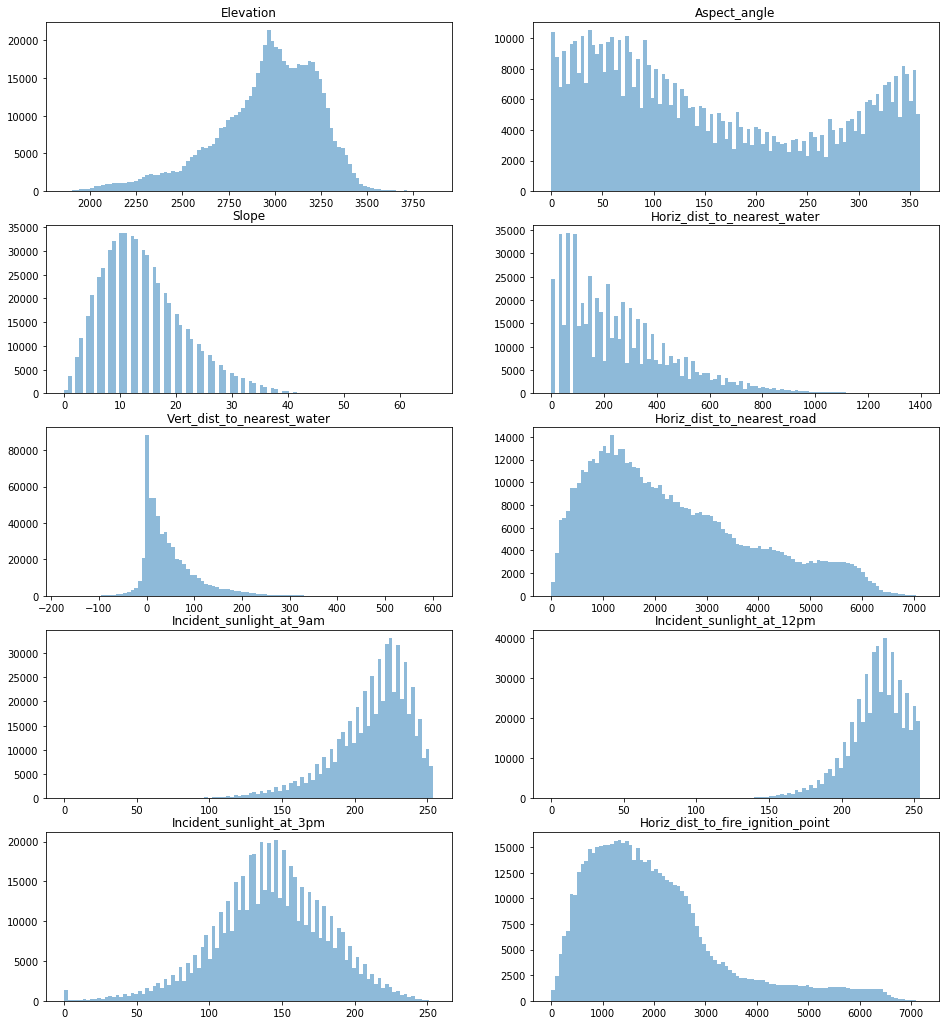

In [7]:
fig = plt.figure(figsize=(16, 18))
layout = (5, 2)
gs = GridSpec(*layout)
axes = [plt.subplot(gs[np.unravel_index(i, layout)]) for i in range(10)]

for i in range(10):
    ax = axes[i]
    ax.set_title(column_names[i])
    hist, bin_edges, _ = ax.hist(data[column_names[i]], bins=100, alpha=0.5)
plt.show()

## Class distributions in the dataset

Let's take a look at how the classes are distributed in the dataset. From the chart below we can see that there are two predominant classes (Spruce/fir and Lodgepole Pine) that make up a bit more than 80% of the total observations. The overall classification accuracy will therefore mainly depend on how well these classes are identified. Furthermore, we need to pay special attention to the classification of the least well represented classes and make sure that they don't get completely ignored by the classifier.

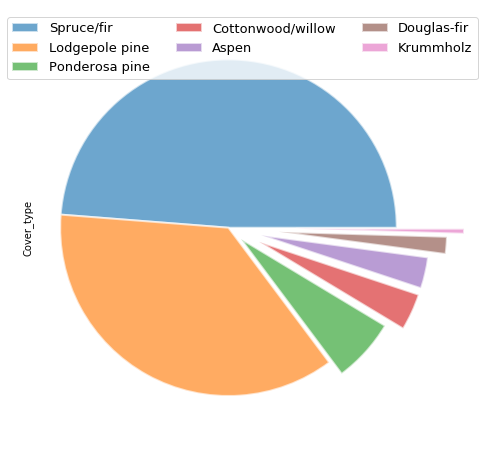

Class percentages:
 [0.48759922 0.36460521 0.06153746 0.03530048 0.02989095 0.01633873
 0.00472796]


In [8]:
class_colours = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig = plt.figure(figsize=(8, 8))
data['Cover_type'].value_counts().plot(
    kind='pie', explode=(0, 0, 0.1, 0.2, 0.2, 0.3, 0.4),
    wedgeprops={'linewidth':2, 'edgecolor': 'w', 'alpha': 0.65}, labels=None,
    colors=class_colours, fontsize=16
)
plt.axis('equal')
plt.legend(labels=cover_types, fontsize=13, ncol=3)
fig.savefig('covertypes_pie_chart_new.svg')
plt.show()

print('Class percentages:\n', data['Cover_type'].value_counts().values / 581012)

## Correlations between features

Below we calculate the column-wise Pearson correlation coefficients to visualise how different features are correlated. In terms of classification, feature correlation can often mean that information is duplicated, and some may say that feature correlation is hurtful for most classifiers. However, for us the graph below merely provides insight into the features and helps us understand the data better.

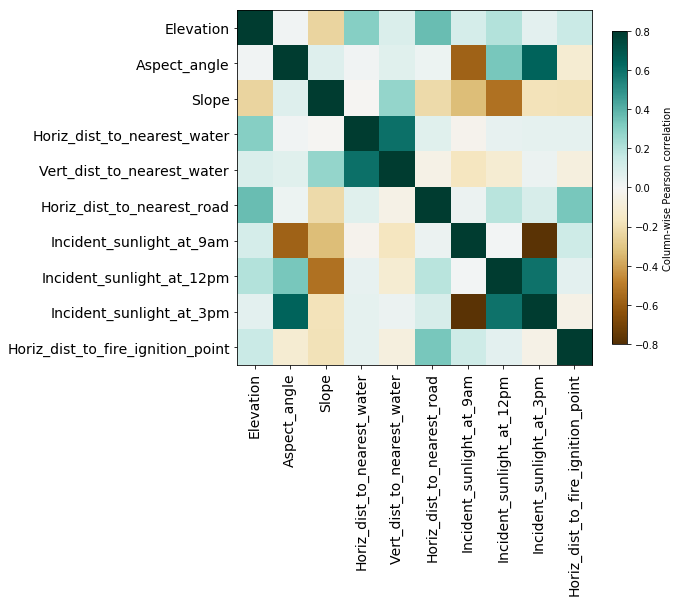

In [9]:
column_correlations = data[column_names[:10]].corr(method='pearson')
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(column_correlations, cmap=plt.cm.BrBG,
          vmin=-0.8, vmax=0.8, interpolation='nearest')
cbar = plt.colorbar(im, fraction=0.04)
cbar.set_label('Column-wise Pearson correlation')
ticks = np.arange(0, 10, 1); labels = np.array(column_names[:10])[ticks]
ax.set_xticks(ticks); ax.set_yticks(ticks)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xticklabels(labels, fontsize=14, rotation=90)

plt.show()

## How features separate classes

The single-most important quality of features in classification is how well they separate the classes. For this, we take a look at the number of observations for each class within a fixed range of each feature. The elevation seems to have the biggest impact on class separation, and indeed we see later on during the classification that this feature rates highest among the feature importances of the Random Forest classifier.

The cell below defines a convenient function that helps us visualise the class distributions as a function of feature range.

In [14]:
labels = data['Cover_type'].values - 1
def plot_class_observations_per_feature(feature_column, name=None, bins=300):
    """
        This function counts the number of class observations for given ranges
        of feature columns. By plotting the resulting histograms, we can observe
        how features separate classes.
    """
    row_indices_split = np.array_split(feature_column.argsort(), bins)
    binned_values = np.linspace(feature_column.min(), feature_column.max(), num=bins)

    # Loop over each set of rows and count the occurrences of each
    # class
    class_counts = np.zeros((bins, 7))
    for i, row_indices in enumerate(row_indices_split):
        # Count classes for this set of observations
        classes, counts = np.unique(labels[row_indices], return_counts=True)
        class_counts[i, classes] = counts

    feature_name = name if name is not None else ''
    fig, ax = plt.subplots(figsize=(16, 5))
    for i in range(7):
        cts = class_counts[:, i]
        ax.fill_between(binned_values, cts, 0, alpha=0.2)
        ax.plot(binned_values, cts, alpha=0.8, label=cover_types[i])
        #ax.bar(binned_values, cts, alpha=0.35 + i*0.05)
    ax.set_ylabel('Class counts')
    ax.set_xlabel(feature_name)
    ax.set_title('Number of class observations per feature: ' + feature_name)
    ax.legend(ncol=4)
    return fig, ax

## Class separation through continuous variables

The plots below show how classes are separated through the continuous variables of the dataset.

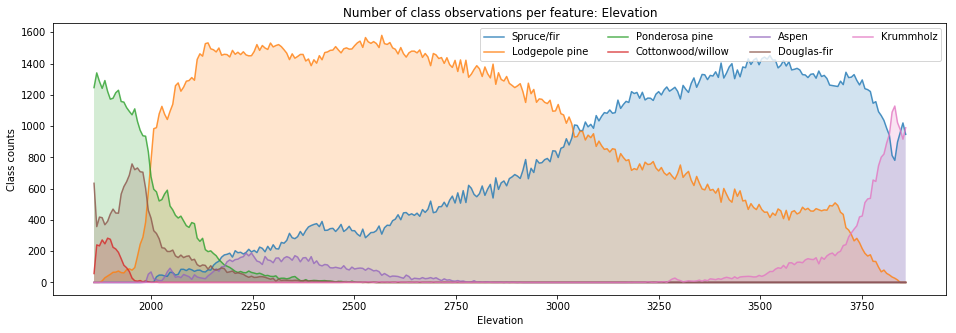

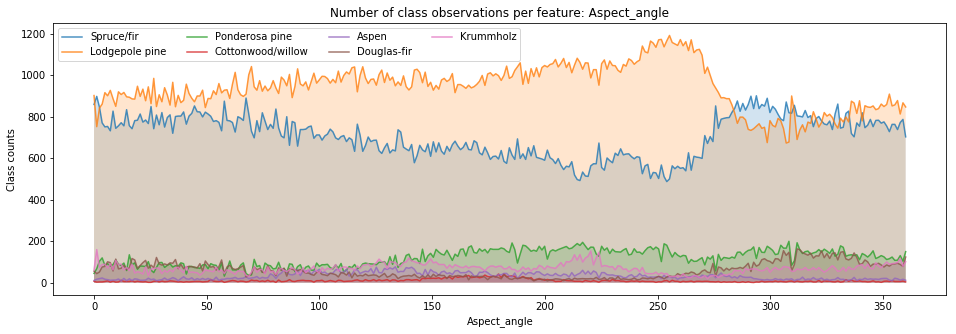

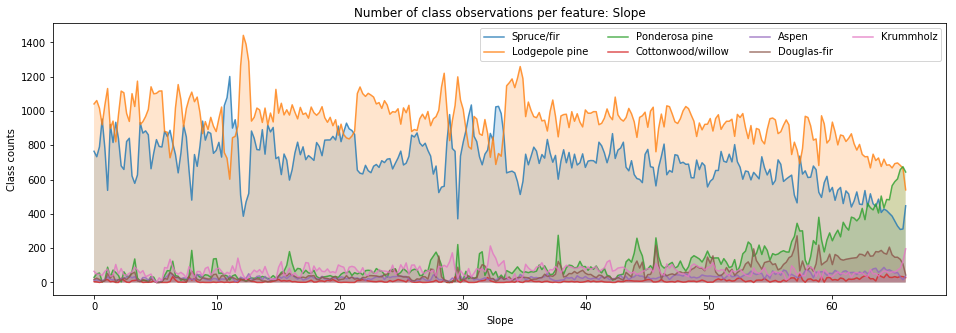

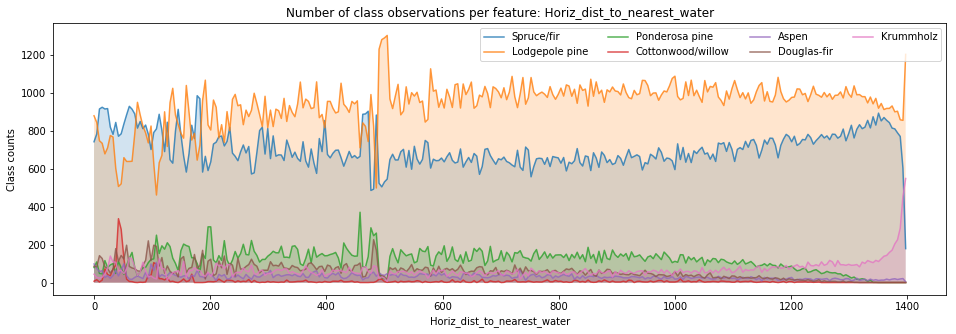

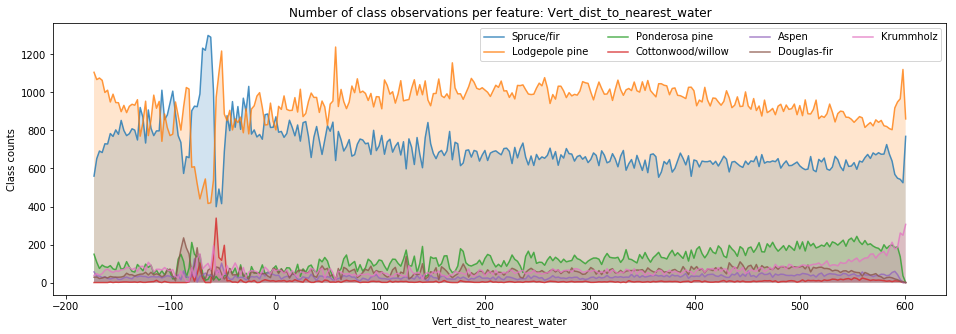

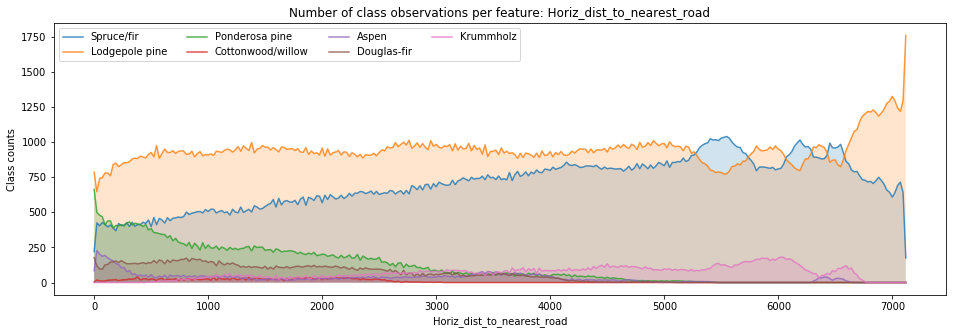

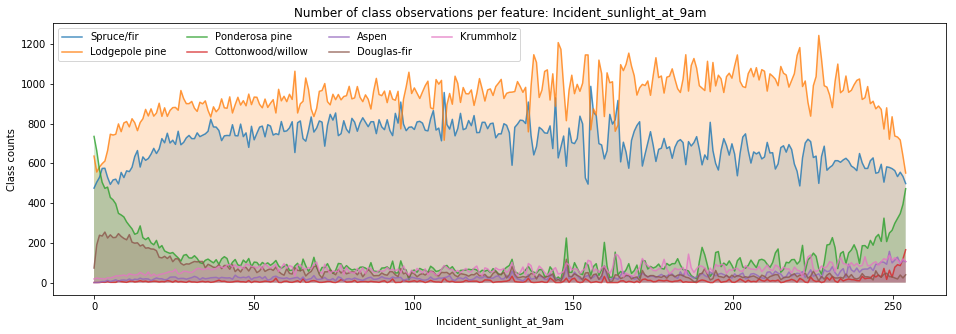

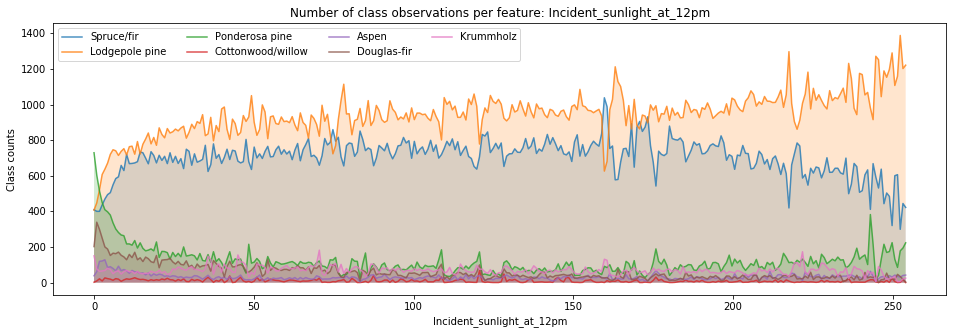

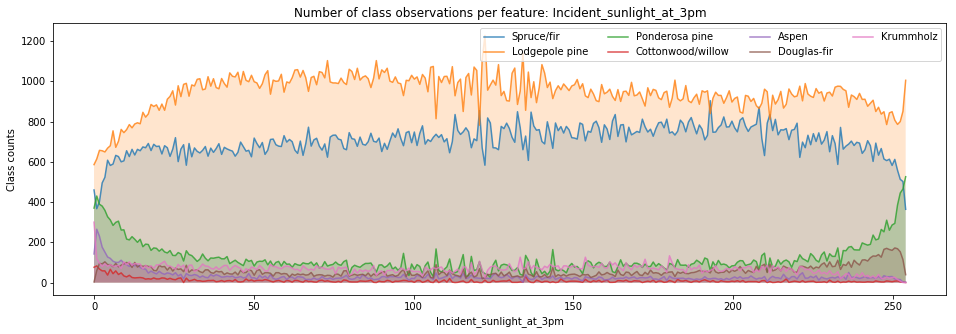

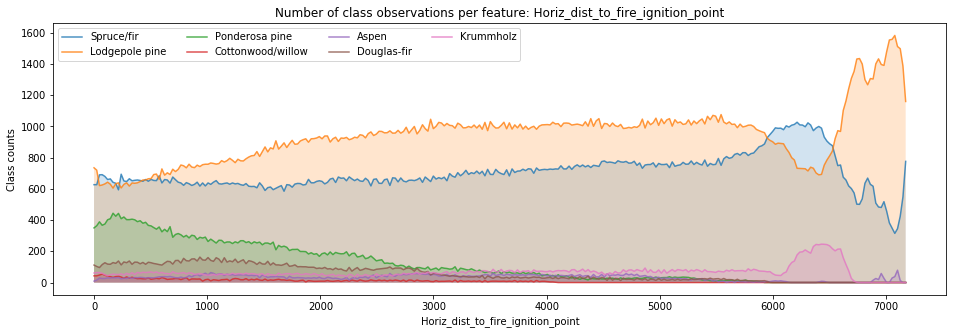

In [15]:
for feature_name in column_names[:10]:
    feature_column = data[feature_name].values
    fig, ax = plot_class_observations_per_feature(
        feature_column, name=feature_name)
plt.show()

## Class separation by soil and wilderness areas and soil type

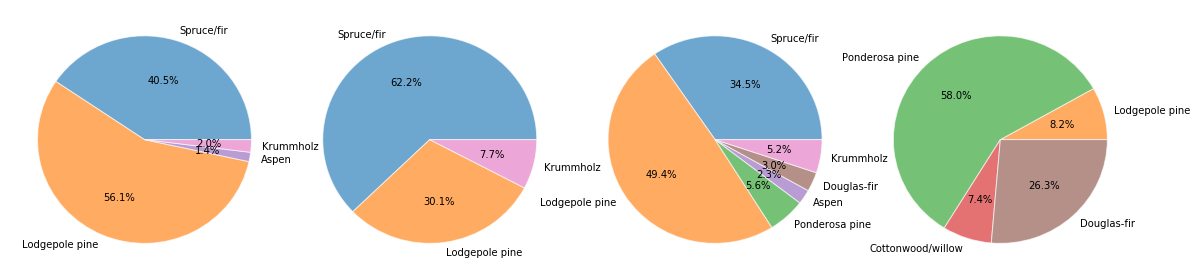

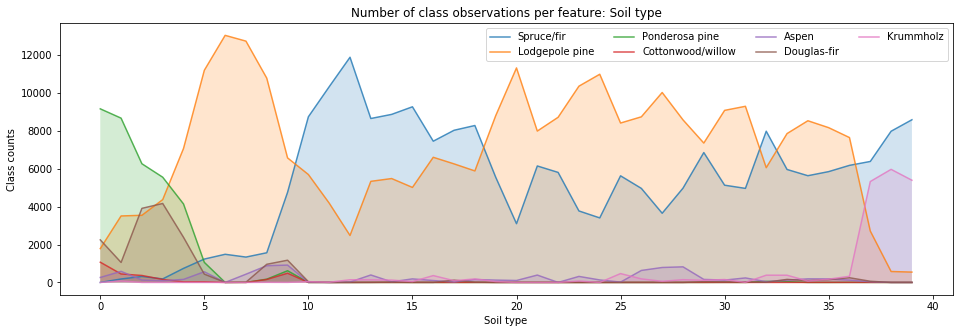

In [21]:
wilderness_areas = data[['Wilderness_area_{}'.format(i) for i in range(4)]].values
labels_per_area = [labels[np.where(w_col == 1)] for w_col in wilderness_areas.T]
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 4)

axes = [plt.subplot(gs[0, i]) for i in range(4)]

for i, ax in enumerate(axes):
    classes, class_counts = np.unique(labels_per_area[i], return_counts=True)
    ax.pie(class_counts, labels=np.array(cover_types)[classes], autopct='%1.1f%%',
        colors=class_colours[classes],
                 wedgeprops={'linewidth':1, 'edgecolor': 'w', 'alpha': 0.65})
    h, l = ax.get_legend_handles_labels()
plt.tight_layout()
plt.show()


soil_types = np.argmax(data[['Soil_type_{}'.format(i) for i in range(40)]].values, axis=1)
plot_class_observations_per_feature(soil_types, 'Soil type', bins=40)
plt.show()

## Feature compression and engineering

For subsequent classification, we will modify the features in two steps:

1. We compress the binary columns by replacing them with a single continuous column that holds indicator values (0-4 for wilderness areas and 0-40 for the soil types).

2. We engineer new features to achieve better class separation.

In [27]:
data_new = compress_and_engineer_features(data)
print(data_new.shape)
print(list(data_new))

(581012, 20)
['Elevation', 'Aspect_angle', 'Slope', 'Horiz_dist_to_nearest_water', 'Vert_dist_to_nearest_water', 'Horiz_dist_to_nearest_road', 'Incident_sunlight_at_9am', 'Incident_sunlight_at_12pm', 'Incident_sunlight_at_3pm', 'Horiz_dist_to_fire_ignition_point', 'Wilderness_area', 'Soil_types', 'Elevation_plus_road_dist', 'Elevation_minus_road_dist', 'Elevation_plus_fire_dist', 'Elevation_minus_fire_dist', 'Elevation_times_soil_types', 'Elevation_times_wArea', 'wArea_times_soil_types', 'Cover_type']


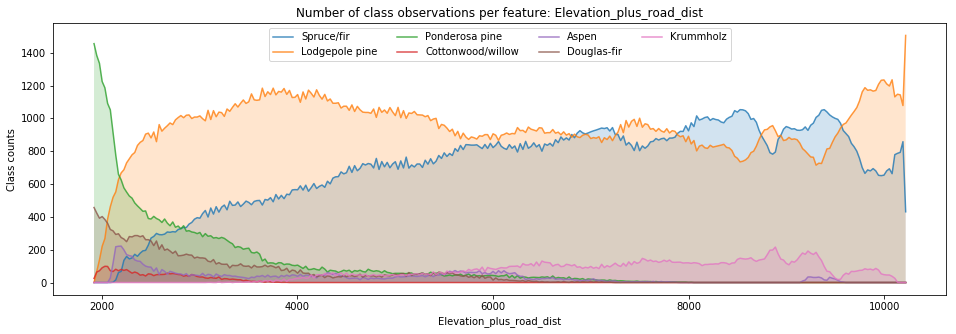

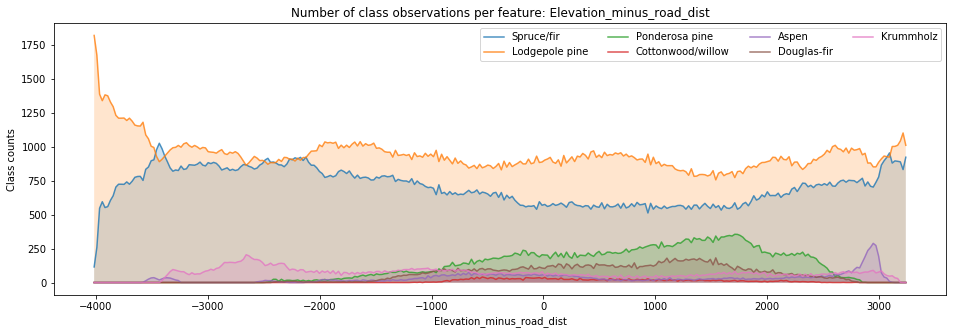

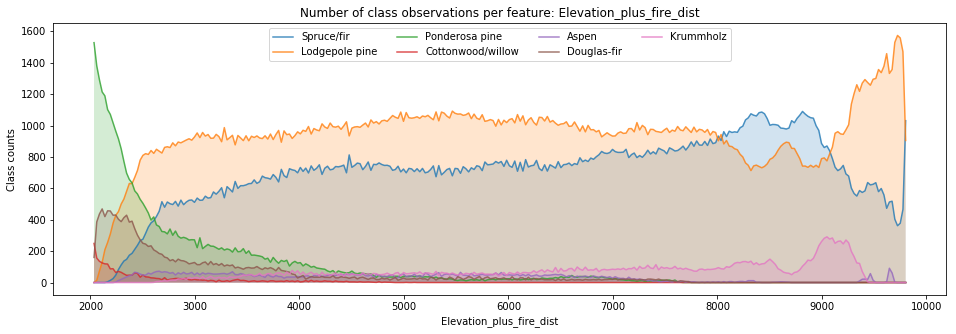

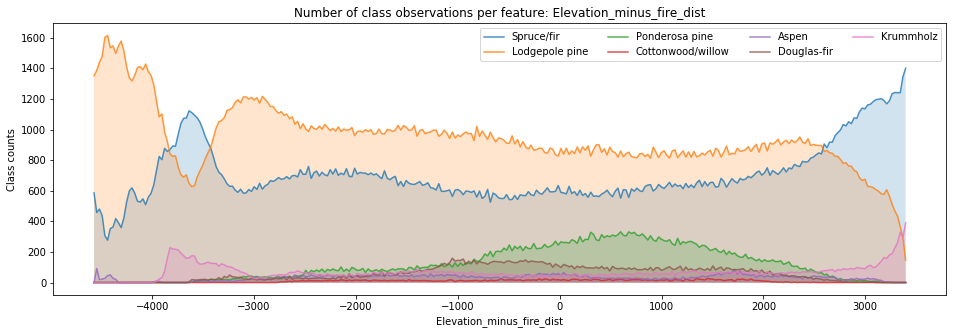

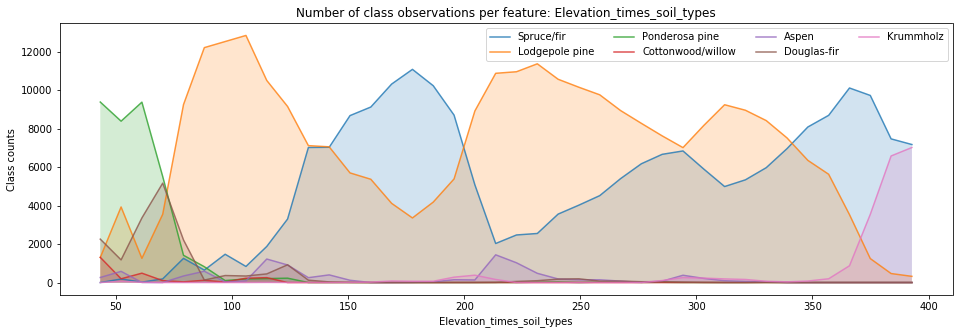

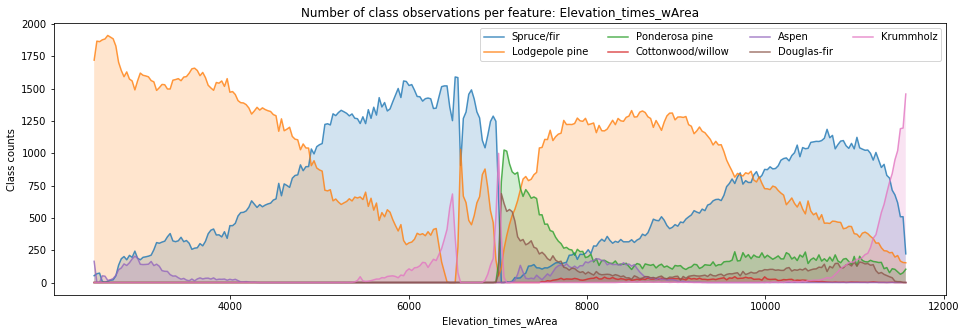

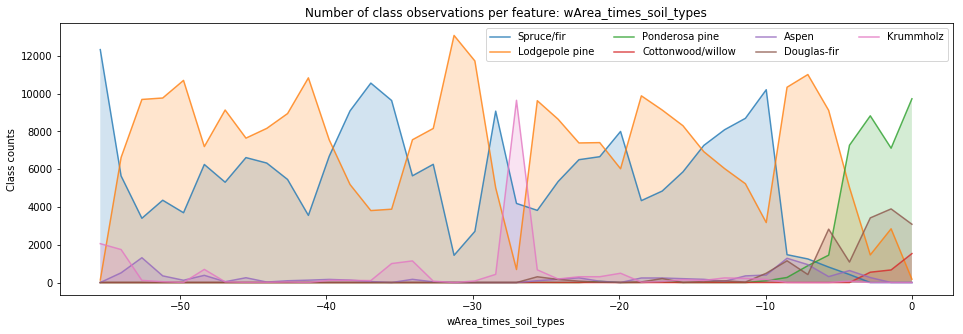

In [30]:
new_column_names = list(data_new)
for feature_name in new_column_names[12:19]:
    feature_column = data_new[feature_name].values
    fig, ax = plot_class_observations_per_feature(
        feature_column, name=feature_name, bins=300 if 'soil_types' not in feature_name else 40)
plt.show()

## Baseline accuracy of the covertype dataset

Below we take a quick peek at the baseline, or null accuracy of the dataset by predicting the most predominant class.

In [35]:
from codes import format_classifier_performance, construct_confusion_matrix
print(format_classifier_performance(construct_confusion_matrix(labels, np.ones_like(labels))))


    Overall Accuracy: 0.488
    Mean Precision:   0.070 +/- 0.171
    Mean Recall:      0.143 +/- 0.350
    Mean F1 Score:    nan +/- nan
    


codes/evaluations.py:107: RuntimeWarning: invalid value encountered in divide
  f1_score = precision * recall / (precision + recall) * 2
